In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

import rasterstats
import xarray as xr

import rioxarray
import stackstac
import pystac_client
import rasterio
from pystac import ItemCollection
import matplotlib.pyplot as plt
import bottleneck as bn
from multiprocessing import Pool
import time
import pyproj
import dask

In [ ]:
from dask.distributed import Client

client = Client()
client

In [91]:
path_to_aoi = r"C:\Users\iidam\Documents\stands_AOI.gpkg"
aoi_data = gpd.read_file(path_to_aoi)
aoi_data_wgs = aoi_data.to_crs(crs="EPSG:4326")

bbox = list(aoi_data.bounds.loc[0])
bbox_wgs = list(aoi_data_wgs.bounds.loc[0])

In [92]:
print(bbox)
print(bbox_wgs)

[596000.0000000009, 6912000.000000004, 614000.0000000009, 6936000.0]
[28.85293582102271, 62.32208325626651, 29.215953867109075, 62.542453897106675]


In [93]:
URL = "https://paituli.csc.fi/geoserver/ogc/stac/v1"
catalog = pystac_client.Client.open(URL)
catalog

<Client id=GeoserverSTACLandingPage>

In [ ]:
"""
search = catalog.search(
    collections=["sentinel_2_11_days_mosaics_at_fmi"],
    datetime="2019-10-31/2021-07-01",
    limit=10
)
items = list(search.get_items())
for item in items:
    print(item)
    for key, asset in item.assets.items():
        href = asset.href
        with rasterio.open(href) as src:
            print(f"Number of bands from asset {key}: {src.count}")
            #print(href)
"""

In [94]:
def get_data(*, item_collection, assets, bbox, epsg, resolution, time_period):
    num_found_items = len(item_collection.items)
    print(f'Found items: {num_found_items}')
    
    gdf = None
    if num_found_items > 0:
        # ItemCollection as GeoJson 
        #stac_json = search.item_collection_as_dict()
        stac_json = item_collection.to_dict()
        
        # Add Item ID to properties to have access to it in GeoPandas
        for a in stac_json['features']:
            a['properties']['title']=a['id']
        
        # GeoJson as GeoPandas dataframe
        gdf = gpd.GeoDataFrame.from_features(stac_json, f"epsg:{epsg}")

    stack = stackstac.stack(
        items=item_collection,
        assets=assets,
        bounds=bbox,
        epsg=epsg,
        resolution=resolution
    ).squeeze()

    #resampled = stack.resample(time=time_period).median("time", skipna=True, keep_attrs=True)

    return gdf, stack

In [95]:
search_pre_2020 = catalog.search(
    bbox=bbox_wgs,
    collections=["sentinel_2_11_days_mosaics_at_fmi"],
    datetime="2019-04-01/2019-06-01"
)

search_post_2020 = catalog.search(
    collections=["sentinel_2_11_days_mosaics_at_fmi"],
    datetime="2020-04-01/2023-10-31",
    bbox=bbox_wgs
)

item_collection_1 = search_pre_2020.item_collection()
#item_collection_2 = search_post_2020.item_collection()
#all_items = item_collection_1.items + item_collection_2.items
all_items = item_collection_1
print(f'Found items: {len(all_items)}')
all_collection = ItemCollection(all_items)

s2_11_d_gdf, s2_11_d_data_all = get_data(
    item_collection=all_collection,
    assets=['b02', 'b03', 'b04', 'b05', 'b06', 'b07', 'b08', 'b8a', 'b11', 'b12','quality_scene_classification'],
    bbox=bbox,
    epsg=3067,
    resolution=10,
    time_period="MS"
)

# get summer months only
s2_11_d_data = s2_11_d_data_all.sel(time=s2_11_d_data_all.time.dt.month.isin([4, 5, 6, 7, 8, 9, 10]))

Found items: 8
Found items: 8


In [96]:
display(s2_11_d_data_all)
display(s2_11_d_data)

<xarray.DataArray 'stackstac-a7daee779455c52590c2d8598293532d' (time: 8,
                                                                band: 11,
                                                                y: 2400, x: 1801)> Size: 3GB
dask.array<fetch_raster_window, shape=(8, 11, 2400, 1801), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 64B 2019-04-01 ... 2019-06-01
    id              (time) <U53 2kB 'Sentinel-2_global_mosaic_dekadi_2019-04-...
  * band            (band) <U28 1kB 'b02' ... 'quality_scene_classification'
  * x               (x) float64 14kB 5.96e+05 5.96e+05 ... 6.14e+05 6.14e+05
  * y               (y) float64 19kB 6.936e+06 6.936e+06 ... 6.912e+06 6.912e+06
    proj:code       <U9 36B 'EPSG:3067'
    end_datetime    (time) <U29 928B '2019-04-10T23:59:59.000+00:00' ... '201...
    start_datetime  (time) <U29 928B '2019-04-01T00:00:00.000+00:00' ... '201...
    title           (band) <U28 1kB 'b02' ... 'quality_scene_classification'
    gsd             float64 8B 20.0
    proj:transform  object 8B {0, 1, 7799840, -20, 20, 50200}
    epsg            int64 8B 3067
Attributes:
    spec:        RasterSpec(epsg=3067, bounds=(596000, 6912000, 614010, 69360...
    crs:         epsg:3067
    transform:   | 10.00, 0.00, 596000.00|\n| 0.00,-10.00, 6936000.00|\n| 0.0...
    resolution:  10

<xarray.DataArray 'stackstac-a7daee779455c52590c2d8598293532d' (time: 8,
                                                                band: 11,
                                                                y: 2400, x: 1801)> Size: 3GB
dask.array<getitem, shape=(8, 11, 2400, 1801), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 64B 2019-04-01 ... 2019-06-01
    id              (time) <U53 2kB 'Sentinel-2_global_mosaic_dekadi_2019-04-...
  * band            (band) <U28 1kB 'b02' ... 'quality_scene_classification'
  * x               (x) float64 14kB 5.96e+05 5.96e+05 ... 6.14e+05 6.14e+05
  * y               (y) float64 19kB 6.936e+06 6.936e+06 ... 6.912e+06 6.912e+06
    proj:code       <U9 36B 'EPSG:3067'
    end_datetime    (time) <U29 928B '2019-04-10T23:59:59.000+00:00' ... '201...
    start_datetime  (time) <U29 928B '2019-04-01T00:00:00.000+00:00' ... '201...
    title           (band) <U28 1kB 'b02' ... 'quality_scene_classification'
    gsd             float64 8B 20.0
    proj:transform  object 8B {0, 1, 7799840, -20, 20, 50200}
    epsg            int64 8B 3067
Attributes:
    spec:        RasterSpec(epsg=3067, bounds=(596000, 6912000, 614010, 69360...
    crs:         epsg:3067
    transform:   | 10.00, 0.00, 596000.00|\n| 0.00,-10.00, 6936000.00|\n| 0.0...
    resolution:  10

In [ ]:
""" produce tiff
stack = s2_11_d_data.sel(band=["b04", "b03", "b02"], time='2023-09-01')/10000
#print(stack)
stack = stack.transpose("band", "y", "x") 

stack.rio.write_crs(3067, inplace=True)
stack.rio.to_raster("heinavesi2.tif")

#ndvi.sel(time='2023-09-01').plot(cmap='RdYlGn')
#s2_11_d_data.sel(time='2023-09-01').plot(cmap='RdYlGn')
raster = rioxarray.open_rasterio("heinavesi2.tif")
print(raster.shape)
print(raster.min().values, raster.max().values)
plt.figure(figsize=(10, 10))
rgb = raster.transpose("y", "x", "band").values
raster = np.clip(raster, 0, 0.4)
plt.imshow(rgb)
plt.axis("off")
plt.show()
raster.close()
"""

In [ ]:
nan_count = s2_11_d_data.isnull().sum().compute().item()
zero_count = (s2_11_d_data == 0).sum().compute().item()
nan_count
zero_count

43224000

In [97]:
#values scaled to [0,1]
s2_11_d_data_reduced = s2_11_d_data.sel(
    band=s2_11_d_data.band.where(~s2_11_d_data.band.isin(["quality_scene_classification"]), drop=True)
)
s2_11_d_data_reduced = (s2_11_d_data_reduced / 10000).astype("float32")

#cloud-masking. saturated or defective pixels, cloud shadows, clouds on medium and high probability, and thin cirrus (classes 0, 1, 3, 8, 9, and 10) were filtered out
qsc = s2_11_d_data.sel(band="quality_scene_classification")
valid_mask = qsc.isin([2, 4, 5, 6, 7])
#n_valid_pixels = valid_mask.sum().compute().item()
s2_11_d_data_masked = s2_11_d_data_reduced.where(valid_mask)
s2_11_d_data_masked = s2_11_d_data_masked.assign_coords(band=s2_11_d_data_reduced.band) #loses metadata otherwise
s2_11_d_data_masked.attrs = s2_11_d_data.attrs
#s2_11_d_data = s2_11_d_data_masked
#s2_11_d_data

In [98]:
s2_11_d_data_masked     

<xarray.DataArray 'stackstac-a7daee779455c52590c2d8598293532d' (time: 8,
                                                                band: 10,
                                                                y: 2400, x: 1801)> Size: 1GB
dask.array<where, shape=(8, 10, 2400, 1801), dtype=float32, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 64B 2019-04-01 ... 2019-06-01
    id              (time) <U53 2kB 'Sentinel-2_global_mosaic_dekadi_2019-04-...
  * x               (x) float64 14kB 5.96e+05 5.96e+05 ... 6.14e+05 6.14e+05
  * y               (y) float64 19kB 6.936e+06 6.936e+06 ... 6.912e+06 6.912e+06
    proj:code       <U9 36B 'EPSG:3067'
    end_datetime    (time) <U29 928B '2019-04-10T23:59:59.000+00:00' ... '201...
    start_datetime  (time) <U29 928B '2019-04-01T00:00:00.000+00:00' ... '201...
    gsd             float64 8B 20.0
    proj:transform  object 8B {0, 1, 7799840, -20, 20, 50200}
    epsg            int64 8B 3067
  * band            (band) <U28 1kB 'b02' 'b03' 'b04' ... 'b8a' 'b11' 'b12'
    title           (band) <U28 1kB 'b02' 'b03' 'b04' ... 'b8a' 'b11' 'b12'
Attributes:
    spec:        RasterSpec(epsg=3067, bounds=(596000, 6912000, 614010, 69360...
    crs:         epsg:3067
    transform:   | 10.00, 0.00, 596000.00|\n| 0.00,-10.00, 6936000.00|\n| 0.0...
    resolution:  10

In [ ]:
#(time, y, x)
pixels_with_zero = (s2_11_d_data == 0).any(dim='band')
indices = np.argwhere(pixels_with_zero.values)
indices

In [14]:
#display(s2_11_d_data)
#s2_11_d_data.compute()
#s2_11_d_data_masked.isna().sum().compute()
#n_valid_pixels = s2_11_d_data_masked.count().sum().compute()
step = 10
total_pixels = 0

for start in range(0, s2_11_d_data.sizes['time'], step):
    chunk = s2_11_d_data_reduced.isel(time=slice(start, start + step)).compute()
    total_pixels += chunk.count().sum().item()
print(total_pixels)

3715259850


In [13]:
step = 10
total_pixels_masked = 0
for start in range(0, s2_11_d_data_masked.sizes['time'], step):
    chunk = s2_11_d_data_masked.isel(time=slice(start, start + step)).compute()
    total_pixels_masked += chunk.count().sum().item()
print(total_pixels_masked)

1973772374


C:\Users\iidam\AppData\Local\Temp\ipykernel_10820\2189619365.py:1: RuntimeWarning: Mean of empty slice
  mean_over_time = np.nanmean(np.where((s2_11_d_data_reduced == 0), np.nan, s2_11_d_data_reduced), axis=0)
C:\Users\iidam\AppData\Local\Temp\ipykernel_10820\2189619365.py:2: RuntimeWarning: Mean of empty slice
  mean_over_time_masked = np.nanmean(np.where((s2_11_d_data_masked == 0), np.nan, s2_11_d_data_masked), axis=0)


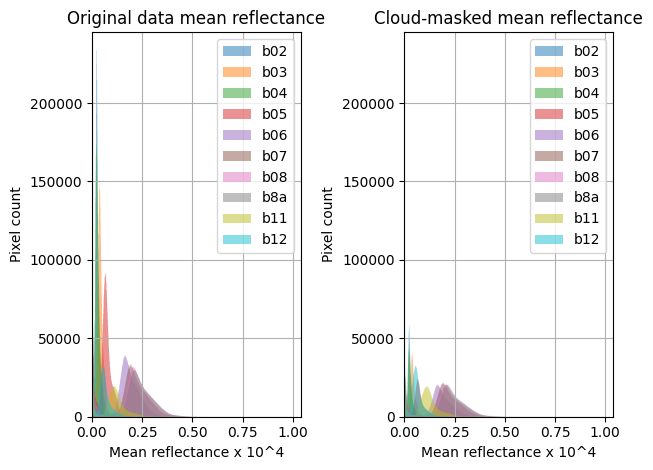

In [64]:
mean_over_time = np.nanmean(np.where((s2_11_d_data_reduced == 0), np.nan, s2_11_d_data_reduced), axis=0)
mean_over_time_masked = np.nanmean(np.where((s2_11_d_data_masked == 0), np.nan, s2_11_d_data_masked), axis=0)
bands, h, w = mean_over_time.shape
bands_masked, h, w = mean_over_time_masked.shape
mean_flat = mean_over_time.reshape(bands, -1)
mean_flat_masked = mean_over_time_masked.reshape(bands_masked, -1)

fig, axs = plt.subplots(1, 2, tight_layout=True)

for i in range(bands):
    values = mean_flat[i][~np.isnan(mean_flat[i])]
    axs[0].hist(values, bins=1000, alpha=0.5, label=s2_11_d_data_reduced["band"][i], histtype='stepfilled')
for i in range(bands_masked):
    values_masked = mean_flat_masked[i][~np.isnan(mean_flat_masked[i])]
    axs[1].hist(values_masked, bins=1000, alpha=0.5, label=s2_11_d_data_masked["band"][i], histtype='stepfilled')

axs[0].set_title('Original data mean reflectance')
axs[1].set_title('Cloud-masked mean reflectance')
axs[0].set_xlabel('Mean reflectance x 10^4')
axs[1].set_xlabel('Mean reflectance x 10^4')
axs[0].set_ylabel('Pixel count')
axs[1].set_ylabel('Pixel count')
axs[0].legend()
axs[1].legend()
axs[0].grid(True)
axs[1].grid(True)
max_y = max(axs[0].get_ylim()[1], axs[1].get_ylim()[1])
axs[0].set_ylim(0, max_y)
axs[1].set_ylim(0, max_y)
max_x = max(axs[0].get_xlim()[1], axs[1].get_xlim()[1])
axs[0].set_xlim(0, max_x)
axs[1].set_xlim(0, max_x)
plt.tight_layout()
plt.show()


In [ ]:
s2_11_d_data_masked

In [100]:
#inspect duplicates
duplicated_data = s2_11_d_data_masked.sel(time=s2_11_d_data_masked["time"].to_index().duplicated(keep=False))
duplicated_data
#print(np.isnan(duplicated_data).sum(dim=('band', 'y', 'x')).compute())  
#s2_11_d_data_masked
#mean_per_band = duplicated_data.groupby("time").mean(dim=["x", "y"]).compute().to_dataframe(name="mean").reset_index()
#nulls_per_band = duplicated_data.isnull().sum(dim=["x","y"]).compute().to_dataframe(name="null_count").reset_index()
#df = pd.merge(mean_per_band, nulls_per_band, on=["time", "band"])¨
#df[["time", "band", "mean", "null_count"]]

#remove duplicates
s2_11_d_data_cleaned = s2_11_d_data_masked.drop_duplicates(dim="time", keep="last")

In [101]:
#temporal linear interpolation of cloudy pixels 
#s2_11_d_data_cleaned = xr.where(s2_11_d_data_cleaned == 0, np.nan, s2_11_d_data_cleaned) #replace zeros with NaN
s2_11_d_data_chunked = s2_11_d_data_cleaned.chunk({'time': -1}) #chunk all time steps into one chunk
S2_11_d_data_interpolated = s2_11_d_data_chunked.interpolate_na(dim='time', method='linear', limit=3, use_coordinate=True) #2 consecutive NaNs at max meaning a month, and at max 
S2_11_d_data_filled = S2_11_d_data_interpolated.chunk({'time': 1, 'y':1024, 'x':1024}) #split chunks back to normal
S2_11_d_data_filled.attrs = s2_11_d_data_masked.attrs
#S2_11_d_data_filled = S2_11_d_data_filled.persist()

In [102]:
S2_11_d_data_filled

<xarray.DataArray 'stackstac-a7daee779455c52590c2d8598293532d' (time: 7,
                                                                band: 10,
                                                                y: 2400, x: 1801)> Size: 1GB
dask.array<rechunk-merge, shape=(7, 10, 2400, 1801), dtype=float32, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 56B 2019-04-01 ... 2019-06-01
    id              (time) <U53 1kB dask.array<chunksize=(1,), meta=np.ndarray>
  * x               (x) float64 14kB 5.96e+05 5.96e+05 ... 6.14e+05 6.14e+05
  * y               (y) float64 19kB 6.936e+06 6.936e+06 ... 6.912e+06 6.912e+06
    proj:code       <U9 36B 'EPSG:3067'
    end_datetime    (time) <U29 812B dask.array<chunksize=(1,), meta=np.ndarray>
    start_datetime  (time) <U29 812B dask.array<chunksize=(1,), meta=np.ndarray>
    gsd             float64 8B 20.0
    proj:transform  object 8B {0, 1, 7799840, -20, 20, 50200}
    epsg            int64 8B 3067
  * band            (band) <U28 1kB 'b02' 'b03' 'b04' ... 'b8a' 'b11' 'b12'
    title           (band) <U28 1kB dask.array<chunksize=(10,), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=3067, bounds=(596000, 6912000, 614010, 69360...
    crs:         epsg:3067
    transform:   | 10.00, 0.00, 596000.00|\n| 0.00,-10.00, 6936000.00|\n| 0.0...
    resolution:  10

In [42]:
print(s2_11_d_data_cleaned.isnull().sum().compute())
print(S2_11_d_data_filled.isnull().sum().compute())
#valid_counts = s2_11_d_data_cleaned.notnull().sum(dim='time')
#valid_counts.max().compute() 

<xarray.DataArray 'stackstac-db53c1c0748d63553ff3687109db26fa' ()> Size: 8B
array(2174077046)
Coordinates:
    gsd      float64 8B 20.0
    epsg     int64 8B 3067
<xarray.DataArray 'stackstac-db53c1c0748d63553ff3687109db26fa' ()> Size: 8B
array(1378305972)
Coordinates:
    gsd      float64 8B 20.0
    epsg     int64 8B 3067


In [ ]:
interpolated_true = s2_11_d_data_cleaned.isnull() & S2_11_d_data_filled.notnull()
interpolated_count = interpolated_true.sum().compute()
interpolated_count

In [104]:
#inspect null values after interpolation
valid_timesteps = S2_11_d_data_filled.notnull().any(dim=('band', 'y', 'x'))
#S2_11_d_data_filled.loc[non_null_timesteps]
s2_11_d_data_filtered = S2_11_d_data_filled.sel(time=valid_timesteps) #remove fully-null timesteps

#s2_11_d_data_filtered.isnull().all(dim=('band', 'y', 'x')).compute()


In [ ]:
s2_11_d_data_filtered.isnull().all(dim=('band', 'y', 'x')).compute()

In [105]:
s2_11_d_data_filtered

<xarray.DataArray 'stackstac-a7daee779455c52590c2d8598293532d' (time: 6,
                                                                band: 10,
                                                                y: 2400, x: 1801)> Size: 1GB
dask.array<getitem, shape=(6, 10, 2400, 1801), dtype=float32, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 48B 2019-04-11 ... 2019-06-01
    id              (time) <U53 1kB dask.array<chunksize=(1,), meta=np.ndarray>
  * x               (x) float64 14kB 5.96e+05 5.96e+05 ... 6.14e+05 6.14e+05
  * y               (y) float64 19kB 6.936e+06 6.936e+06 ... 6.912e+06 6.912e+06
    proj:code       <U9 36B 'EPSG:3067'
    end_datetime    (time) <U29 696B dask.array<chunksize=(1,), meta=np.ndarray>
    start_datetime  (time) <U29 696B dask.array<chunksize=(1,), meta=np.ndarray>
    gsd             float64 8B 20.0
    proj:transform  object 8B {0, 1, 7799840, -20, 20, 50200}
    epsg            int64 8B 3067
  * band            (band) <U28 1kB 'b02' 'b03' 'b04' ... 'b8a' 'b11' 'b12'
    title           (band) <U28 1kB dask.array<chunksize=(10,), meta=np.ndarray>
Attributes:
    spec:        RasterSpec(epsg=3067, bounds=(596000, 6912000, 614010, 69360...
    crs:         epsg:3067
    transform:   | 10.00, 0.00, 596000.00|\n| 0.00,-10.00, 6936000.00|\n| 0.0...
    resolution:  10

In [ ]:
interp_count = interpolated_true.mean(dim='band').sum(dim='time').plot() #fix this
plt.title('Number of Interpolated Time Steps per Pixel')
plt.show()

In [ ]:
print("Null values in cleaned data = ", np.isnan(s2_11_d_data_cleaned).sum(dim=('time', 'band', 'y', 'x')).compute())
print("Null values in interpolated data = ", np.isnan(S2_11_d_data_filled).sum(dim=('time', 'band', 'y', 'x')).compute())

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(s2_11_d_data_masked.sel(band='b04').values.flatten(), bins=50, range=(0,1), alpha=0.5, color ="#069AF3", label="Cloud-masked") #blue
plt.hist(s2_11_d_data.sel(band='b04').values.flatten(), bins=50, range=(0,1), alpha=0.5, color ="#054907", label="original") #DARK GREEN

plt.xlabel("b04 reflectance values")
plt.title("b04")  
plt.legend()                    
plt.grid(True)                  

plt.show()

In [106]:
#compute normalized difference indices
def normalized_diff(a, b):
    return (a - b) / (a + b + 1e-6)

b03 = s2_11_d_data_filtered.sel(band='b03')
b04 = s2_11_d_data_filtered.sel(band='b04') #red
b08 = s2_11_d_data_filtered.sel(band='b08') #NIR
b11 = s2_11_d_data_filtered.sel(band='b11') #SWIR
b12 = s2_11_d_data_filtered.sel(band = 'b12')

ndvi = normalized_diff(b08, b04)
ndti = normalized_diff(b11, b12)
ndsi = normalized_diff(b03, b11)
ndmi = normalized_diff(b08, b11)
ndbi = normalized_diff(b11, b08)

indexes = [ndvi, ndti, ndsi, ndmi, ndbi]
index_names = ['ndvi', 'ndti', 'ndsi', 'ndmi', 'ndbi']

In [ ]:
for array, name in zip(indexes, index_names):
    array.coords['band'] = name
    array.coords['title'] = name
s2_11_d_index = xr.concat(indexes, dim='band')
s2_11_d_index = s2_11_d_index.transpose('time', 'band', 'y', 'x')
s2_11_d_index.attrs = s2_11_d_data_filtered.attrs

<xarray.DataArray 'stackstac-a7daee779455c52590c2d8598293532d' (band: 5,
                                                                time: 6,
                                                                y: 2400, x: 1801)> Size: 519MB
dask.array<concatenate, shape=(5, 6, 2400, 1801), dtype=float32, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 48B 2019-04-11 ... 2019-06-01
    id              (time) <U53 1kB dask.array<chunksize=(1,), meta=np.ndarray>
  * x               (x) float64 14kB 5.96e+05 5.96e+05 ... 6.14e+05 6.14e+05
  * y               (y) float64 19kB 6.936e+06 6.936e+06 ... 6.912e+06 6.912e+06
    proj:code       <U9 36B 'EPSG:3067'
    end_datetime    (time) <U29 696B dask.array<chunksize=(1,), meta=np.ndarray>
    start_datetime  (time) <U29 696B dask.array<chunksize=(1,), meta=np.ndarray>
    gsd             float64 8B 20.0
    proj:transform  object 8B {0, 1, 7799840, -20, 20, 50200}
    epsg        

In [112]:
#s2_11_d_index
s2_11_d_index.sel(band="ndvi").where(s2_11_d_index.sel(band="ndvi") < 0).sum(dim=["x", "y"]).compute()

KeyboardInterrupt: 

In [ ]:
b04 = s2_11_d_data.sel(band='b04')
b08 = s2_11_d_data.sel(band='b08')
ndvi_manual = ((b08 - b04) / (b08 + b04 + 1e-6))
ndvi_manual.sel(time='2023-09-01').plot(cmap='RdYlGn')
s2_11_d_index.sel(band='ndvi', time='2023-09-01').plot(cmap='RdYlGn')


In [113]:
path_to_training_data = r"C:\Users\iidam\Documents\stands_Training_data.gpkg"
training_data = gpd.read_file(path_to_training_data)
training_data.head()    
training_data[training_data["SPECIES"] == 1.0].head() # species: 1.0 = pine, 2.0 = six, 3.0 = deciduous tree



,fid_1,ID,XCOORD,YCOORD,HEIGHT,SPECIES,Shape_Length,Shape_Area,INV_UNIT,PAR_UNIT,...,L_Ch3_LI5_IP2,L_Ch3_LI5_IP3,L_Ch3_LI5_IA1,L_Ch3_LI5_IA2,L_Ch3_LI5_IA3,L_Ch3_D_RF,L_Ch3_D_RL,L_Ch3_D_RI,L_Ch3_D_RO,geometry
85,3267460.0,25923,605207.745,6914930.625,13.020000,1.0,3.0,0.5000,22454085,NaN,...,48314.0,57519.0,48908.500000,34837.000000,48314.000000,0.300000,0.100000,0.200000,0.400000,"MULTIPOLYGON (((605207.37 6914931, 605208.12 6..."
87,3267592.0,25936,605206.370,6914928.500,26.784500,1.0,21.0,14.7500,22454087,NaN,...,44658.0,50560.0,28141.118644,35534.195122,40963.642857,0.246459,0.240793,0.101983,0.410765,"MULTIPOLYGON (((605205.62 6914931, 605206.37 6..."
88,3267631.0,71390,605215.370,6914926.875,26.172701,1.0,17.5,12.5625,22454088,NaN,...,43205.0,53951.0,24637.500000,19468.000000,36023.777778,0.328402,0.310651,0.213018,0.147929,"MULTIPOLYGON (((605215.37 6914928.5, 605216.62..."
89,3267654.0,25949,605199.370,6914927.125,23.370899,1.0,22.0,16.6875,22454089,NaN,...,42500.0,48622.0,20974.533333,26476.333333,35827.964286,0.311804,0.338530,0.175947,0.173719,"MULTIPOLYGON (((605201.12 6914929.5, 605201.37..."
90,3267700.0,27000,605210.370,6914927.250,23.829399,1.0,24.5,17.3125,22454090,NaN,...,49063.0,56462.0,22169.680000,26246.472727,38795.742857,0.304651,0.311628,0.246512,0.137209,"MULTIPOLYGON (((605209.37 6914930, 605209.62 6..."


In [114]:
@dask.delayed
def stats_for_day_band(vector_df, band, date_str):
    band_title = str(band.title.values).upper()
    column_name = f"S2_{date_str}_{band_title}"

    transform = band.transform
    band_data = band.compute().data

    stats = rasterstats.zonal_stats(vector_df.geometry,
                                    band_data,
                                    affine=transform,
                                    stats="mean",
                                    all_touched=True)
    
    stats = pd.Series(
        # Get the calculated mean values out of the dictionaries
        data=[item["mean"] for item in stats],
        index=vector_df.index,
        name=f"{column_name}_MEAN"
    )
    
    return stats 

In [115]:
def calculate_statistics_parallel(vector_df, raster_data):
    stats_list = []

    # Loop through time dimension
    for t in raster_data:
        date_str = np.datetime_as_string(t.time.values, unit="D")
        print("Calculating statistics for", date_str)


        # Loop through bands
        for band in t:
            print("\tCalculating statistics for", str(band.title.values))
            stats_list.append(stats_for_day_band(vector_df, band, date_str))
                
    return stats_list

In [ ]:
stats_list = calculate_statistics_parallel(training_data, s2_11_d_data_filtered)
stats = dask.compute(*stats_list)
# Combine all the series into a single df
s2_11_d_stats = pd.concat(stats, axis=1)
s2_11_d_stats

Calculating statistics for 2019-04-11
	Calculating statistics for b02
	Calculating statistics for b03
	Calculating statistics for b04
	Calculating statistics for b05
	Calculating statistics for b06
	Calculating statistics for b07
	Calculating statistics for b08
	Calculating statistics for b8a
	Calculating statistics for b11
	Calculating statistics for b12
Calculating statistics for 2019-04-21
	Calculating statistics for b02
	Calculating statistics for b03
	Calculating statistics for b04
	Calculating statistics for b05
	Calculating statistics for b06
	Calculating statistics for b07
	Calculating statistics for b08
	Calculating statistics for b8a
	Calculating statistics for b11
	Calculating statistics for b12
Calculating statistics for 2019-05-01
	Calculating statistics for b02
	Calculating statistics for b03
	Calculating statistics for b04
	Calculating statistics for b05
	Calculating statistics for b06
	Calculating statistics for b07
	Calculating statistics for b08
	Calculating statistic

In [ ]:
index_stats_list = calculate_statistics_parallel(training_data, s2_11_d_index)
stats = dask.compute(*index_stats_list)
# Combine all the series into a single df
s2_11_d_index_stats = pd.concat(stats, axis=1)
s2_11_d_index_stats

In [ ]:
#rows should match

In [ ]:
#s2_11_d_stats["polygon_id"] = s2_11_d_stats.index
s2_11_d_index_stats["polygon_id"] = s2_11_d_index_stats.index

In [70]:
#inspect duplicates
band_cols = [col for col in s2_11_d_stats.columns if col.startswith('S2_') and col.endswith('_MEAN')]
df_inspect = s2_11_d_stats[['polygon_id'] + band_cols].copy()
df_stacked = df_inspect.melt(id_vars='polygon_id', var_name='bands', value_name='mean_val')
duplicates = df_stacked.groupby(['polygon_id', 'bands']).size().reset_index(name='count')
duplicates = duplicates[duplicates['count'] > 1]
duplicates

,polygon_id,bands,count


In [40]:
#remove all-Nan columns
print(s2_11_d_stats.columns[s2_11_d_stats.isna().sum() == 3919].tolist())
#s2_11_d_stats["S2_2019-05-21_B02_MEAN"] #print duplicates
# Keep only columns that don't have exactly 3919 NaNs / remove duplicates (only if all bands present!)
#keep_cols = s2_11_d_stats.isna().sum(axis=0).values != 3919 
#s2_11_d_stats = s2_11_d_stats.iloc[:, keep_cols]
#print(s2_11_d_stats["S2_2019-05-21_B02_MEAN"]) #inspect that actual observations didn't get removed

[]


In [41]:
rows, cols = np.where(s2_11_d_stats.values == 0)
zero_df = pd.DataFrame({
    'row': s2_11_d_stats.index[rows],
    'band': s2_11_d_stats.columns[cols],
    'value': s2_11_d_stats.values[rows, cols]
})
zero_df
zero_rows = zero_df[zero_df['band'].str.contains(r'S2_\d{4}-\d{2}-\d{2}_.+_MEAN', na=False)]
zero_rows['date'] = zero_rows['band'].str.extract(r'S2_(\d{4}-\d{2}-\d{2})')
zero_counts = zero_rows.groupby('date').size().reset_index(name='zero_count')
zero_counts

,date,zero_count


In [ ]:
#s2_11_d_stats.isna().sum()
#s2_11_d_stats.loc[:,(s2_11_d_stats.isna().sum() < 400) & (s2_11_d_stats.isna().sum() > 200)]

#df = s2_11_d_stats.isna().sum().to_frame('n_missing')
#df[df["n_misssing"] > 0]
#s2_11_d_stats.isna().sum(axis=1)
#s2_11_d_stats[s2_11_d_stats.isna().sum(axis=1) > 1]  ¨
s2_11_d_index_stats.isna().sum()

S2_2019-04-11_NDVI_MEAN    2277
S2_2019-04-11_NDTI_MEAN    2277
S2_2019-04-11_NDSI_MEAN    2277
S2_2019-04-11_NDMI_MEAN    2277
S2_2019-04-11_NDBI_MEAN    2277
S2_2019-04-21_NDVI_MEAN     380
S2_2019-04-21_NDTI_MEAN     380
S2_2019-04-21_NDSI_MEAN     380
S2_2019-04-21_NDMI_MEAN     380
S2_2019-04-21_NDBI_MEAN     380
S2_2019-05-01_NDVI_MEAN     380
S2_2019-05-01_NDTI_MEAN     380
S2_2019-05-01_NDSI_MEAN     380
S2_2019-05-01_NDMI_MEAN     380
S2_2019-05-01_NDBI_MEAN     380
S2_2019-05-11_NDVI_MEAN       0
S2_2019-05-11_NDTI_MEAN       0
S2_2019-05-11_NDSI_MEAN       0
S2_2019-05-11_NDMI_MEAN       0
S2_2019-05-11_NDBI_MEAN       0
S2_2019-05-21_NDVI_MEAN       0
S2_2019-05-21_NDTI_MEAN       0
S2_2019-05-21_NDSI_MEAN       0
S2_2019-05-21_NDMI_MEAN       0
S2_2019-05-21_NDBI_MEAN       0
S2_2019-06-01_NDVI_MEAN       0
S2_2019-06-01_NDTI_MEAN       0
S2_2019-06-01_NDSI_MEAN       0
S2_2019-06-01_NDMI_MEAN       0
S2_2019-06-01_NDBI_MEAN       0
polygon_id                    0
dtype: i

In [43]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(s2_11_d_stats.describe())

,S2_2019-06-01_B02_MEAN,S2_2019-06-01_B03_MEAN,S2_2019-06-01_B04_MEAN,S2_2019-06-01_B05_MEAN,S2_2019-06-01_B06_MEAN,S2_2019-06-01_B07_MEAN,S2_2019-06-01_B08_MEAN,S2_2019-06-01_B8A_MEAN,S2_2019-06-01_B11_MEAN,S2_2019-06-01_B12_MEAN,S2_2019-06-11_B02_MEAN,S2_2019-06-11_B03_MEAN,S2_2019-06-11_B04_MEAN,S2_2019-06-11_B05_MEAN,S2_2019-06-11_B06_MEAN,S2_2019-06-11_B07_MEAN,S2_2019-06-11_B08_MEAN,S2_2019-06-11_B8A_MEAN,S2_2019-06-11_B11_MEAN,S2_2019-06-11_B12_MEAN,S2_2019-06-21_B02_MEAN,S2_2019-06-21_B03_MEAN,S2_2019-06-21_B04_MEAN,S2_2019-06-21_B05_MEAN,S2_2019-06-21_B06_MEAN,S2_2019-06-21_B07_MEAN,S2_2019-06-21_B08_MEAN,S2_2019-06-21_B8A_MEAN,S2_2019-06-21_B11_MEAN,S2_2019-06-21_B12_MEAN,polygon_id
count,3919.000000,3919.000000,3919.000000,3919.000000,3919.000000,3919.000000,3919.000000,3919.000000,3919.000000,3919.000000,3919.000000,3528.000000,3919.000000,3528.000000,3919.000000,3919.000000,3919.000000,3919.000000,3919.000000,3919.000000,3528.000000,3528.000000,3528.000000,3528.000000,3528.000000,3528.000000,3528.000000,3528.000000,3528.000000,3528.000000,3919.000000
mean,0.024614,0.035808,0.022622,0.058524,0.145990,0.173539,0.176265,0.188059,0.094952,0.048460,0.019696,0.037535,0.019262,0.058578,0.153425,0.183536,0.195484,0.200224,0.093379,0.045811,0.029468,0.039067,0.024740,0.058555,0.163565,0.195886,0.208055,0.213632,0.092263,0.045851,1959.000000
std,0.005595,0.008071,0.006817,0.013578,0.030208,0.035626,0.036611,0.038550,0.027738,0.015659,0.003434,0.008983,0.005390,0.013404,0.021274,0.025120,0.027044,0.026637,0.020764,0.012396,0.014091,0.014962,0.014059,0.020516,0.040256,0.047826,0.048979,0.051724,0.029906,0.022173,1131.462181
min,0.000100,0.000100,0.000100,0.000100,0.017300,0.023800,0.022700,0.027500,0.002500,0.002000,0.010600,0.015400,0.008600,0.024000,0.077200,0.090400,0.095700,0.102900,0.045500,0.020500,0.000400,0.003200,0.001600,0.006100,0.022800,0.027100,0.025000,0.029400,0.008800,0.003700,0.000000
25%,0.023000,0.033100,0.019300,0.053300,0.135600,0.161200,0.163000,0.175900,0.080900,0.040150,0.017229,0.032000,0.015650,0.049988,0.137600,0.164700,0.175500,0.179900,0.077700,0.037100,0.019819,0.029700,0.017600,0.046200,0.137800,0.168012,0.180050,0.183538,0.070500,0.032550,979.500000
50%,0.025200,0.036000,0.021750,0.058500,0.145200,0.174150,0.177000,0.189400,0.092800,0.046400,0.019200,0.036431,0.017975,0.057000,0.149750,0.179400,0.190500,0.196300,0.089000,0.043233,0.025875,0.035900,0.021800,0.055500,0.160675,0.191500,0.204800,0.209300,0.089500,0.042800,1959.000000
75%,0.027400,0.039200,0.025300,0.063500,0.162225,0.193650,0.196850,0.209000,0.106500,0.054900,0.021250,0.041900,0.021133,0.065000,0.166700,0.199075,0.212700,0.216200,0.103400,0.051000,0.035700,0.044900,0.027000,0.066412,0.185500,0.220600,0.234500,0.240600,0.107100,0.052908,2938.500000
max,0.050050,0.062950,0.056775,0.098600,0.217950,0.264300,0.263400,0.288550,0.183900,0.105200,0.042900,0.082000,0.057100,0.146400,0.246900,0.304400,0.300000,0.314400,0.174300,0.110200,0.105900,0.132300,0.165100,0.242900,0.369700,0.427100,0.376950,0.460400,0.268800,0.267900,3918.000000


In [ ]:
# check that no duplicates exist
#s2_11_d_stats.columns[s2_11_d_stats.columns.duplicated()]
s2_11_d_index_stats.columns[s2_11_d_index_stats.columns.duplicated()]

Index([], dtype='object')

In [ ]:
# convert to long form index
value_columns = [col for col in s2_11_d_index_stats.columns if col != ('polygon_id')]
s2_11_d_long_index = s2_11_d_index_stats.melt(id_vars=['polygon_id'],
                  value_vars=value_columns,
                  var_name='bands',
                  value_name='mean_val')

s2_11_d_long_index[['year', 'month', 'day', 'band']] = s2_11_d_long_index['bands'].str.extract(r'S2_(\d{4})-(\d{2})-(\d{2})_(.+)')

s2_11_d_long_index['date'] = pd.to_datetime(s2_11_d_long_index[['year', 'month', 'day']])
s2_11_d_long_index['year'] = s2_11_d_long_index['year'].astype(int)
#s2_11_d_long['day_of_year'] = s2_11_d_long['date'].dt.dayofyear

apr_1 = 91
oct_31 = 304
season_length = oct_31 - apr_1
#s2_11_d_long['position_in_season'] = s2_11_d_long['day_of_year']-apr_1/ season_length

s2_11_d_long_index = s2_11_d_long_index.pivot(
    columns='band',
    index=['polygon_id', 'year', 'date'],
    values='mean_val'
)
s2_11_d_long_index.columns.name = None 
s2_11_d_long_index = s2_11_d_long_index.reset_index()

#position = s2_11_d_long[['polygon_id', 'year', 'day_of_year', 'position_in_season']].drop_duplicates()
#s2_11_pivot = s2_11_d_long.merge(position, on=['polygon_id', 'year', 'day_of_year'], how='left')

#s2_11_d_long.loc[s2_11_d_long["date"]== "2019-06-11"]
s2_11_d_long_index


,polygon_id,year,date,NDBI_MEAN,NDMI_MEAN,NDSI_MEAN,NDTI_MEAN,NDVI_MEAN
0,0,2019,2019-04-11,NaN,NaN,NaN,NaN,NaN
1,0,2019,2019-04-21,-0.350606,0.350606,-0.290424,0.248247,0.633689
2,0,2019,2019-05-01,-0.276076,0.276076,-0.260609,0.247677,0.540195
3,0,2019,2019-05-11,-0.102078,0.102078,-0.213280,0.246716,0.323492
4,0,2019,2019-05-21,-0.422926,0.422926,-0.454218,0.348719,0.842005
...,...,...,...,...,...,...,...,...
23509,3918,2019,2019-04-21,-0.255010,0.255010,-0.331443,0.236880,0.615282
23510,3918,2019,2019-05-01,-0.247930,0.247930,-0.418895,0.266873,0.679863
23511,3918,2019,2019-05-11,-0.241910,0.241910,-0.524358,0.306640,0.756392
23512,3918,2019,2019-05-21,-0.322858,0.322858,-0.442453,0.293466,0.778134


In [ ]:
# convert to long form
value_columns = [col for col in s2_11_d_stats.columns if col != ('polygon_id')]
s2_11_d_long = s2_11_d_stats.melt(id_vars=['polygon_id'],
                  value_vars=value_columns,
                  var_name='bands',
                  value_name='mean_val')

s2_11_d_long[['year', 'month', 'day', 'band']] = s2_11_d_long['bands'].str.extract(r'S2_(\d{4})-(\d{2})-(\d{2})_(.+)')

s2_11_d_long['date'] = pd.to_datetime(s2_11_d_long[['year', 'month', 'day']])
s2_11_d_long['year'] = s2_11_d_long['year'].astype(int)
#s2_11_d_long['day_of_year'] = s2_11_d_long['date'].dt.dayofyear

apr_1 = 91
oct_31 = 304
season_length = oct_31 - apr_1
#s2_11_d_long['position_in_season'] = s2_11_d_long['day_of_year']-apr_1/ season_length

s2_11_d_long = s2_11_d_long.pivot(
    columns='band',
    index=['polygon_id', 'year', 'date'],
    values='mean_val'
)
s2_11_d_long.columns.name = None 
s2_11_d_long = s2_11_d_long.reset_index()

#position = s2_11_d_long[['polygon_id', 'year', 'day_of_year', 'position_in_season']].drop_duplicates()
#s2_11_pivot = s2_11_d_long.merge(position, on=['polygon_id', 'year', 'day_of_year'], how='left')

#s2_11_d_long.loc[s2_11_d_long["date"]== "2019-06-11"]
s2_11_d_long


,polygon_id,year,date,B02_MEAN,B03_MEAN,B04_MEAN,B05_MEAN,B06_MEAN,B07_MEAN,B08_MEAN,B11_MEAN,B12_MEAN,B8A_MEAN
0,0,2019,2019-06-01,0.02700,0.03970,0.02090,0.06220,0.1823,0.21160,0.22330,0.0980,0.04570,0.22670
1,0,2019,2019-06-11,0.02000,0.00000,0.01760,0.00000,0.1622,0.21140,0.21880,0.0866,0.03710,0.23250
2,0,2019,2019-06-21,0.01230,0.01960,0.01180,0.03130,0.1073,0.13150,0.13610,0.0439,0.01920,0.13310
3,1,2019,2019-06-01,0.02700,0.03970,0.02090,0.06220,0.1823,0.21160,0.22330,0.0980,0.04570,0.22670
4,1,2019,2019-06-11,0.02000,0.00000,0.01760,0.00000,0.1622,0.21140,0.21880,0.0866,0.03710,0.23250
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11752,3917,2019,2019-06-11,0.01900,0.00000,0.01850,0.00000,0.1394,0.16710,0.18320,0.0903,0.04680,0.17460
11753,3917,2019,2019-06-21,0.01820,0.02970,0.01770,0.05070,0.1443,0.16960,0.17550,0.0883,0.04090,0.18660
11754,3918,2019,2019-06-01,0.02815,0.03540,0.02145,0.05105,0.1398,0.16545,0.16675,0.0738,0.03340,0.18030
11755,3918,2019,2019-06-11,0.01640,0.00000,0.01610,0.00000,0.1363,0.16470,0.17635,0.0867,0.04165,0.18075


In [ ]:
"""
print(s2_11_d_long[s2_11_d_long.isna().sum(axis=1) > 0])
bands = s2_11_d_long.filter(regex='MEAN$', axis=1).columns
zero_dates = (
    s2_11_d_long.groupby(['date', 'polygon_id'])[bands]
    .apply(lambda group: (group.isna().all())
))
zero_dates[zero_dates]
"""

print(s2_11_d_long.isna().sum()) #count the NaNs in all columns

# drop timesteps for which all band values are null
band_values = s2_11_d_long.filter(regex='MEAN$', axis=1)
band_cols = band_values.columns.tolist()
mask = band_values.isna().all(axis=1)
print(s2_11_d_long.loc[mask])
s2_11_d_long_nan_free = s2_11_d_long.dropna(subset=band_cols)
print("Before:", s2_11_d_long.shape[0])
print("After: ", s2_11_d_long_nan_free.shape[0])
#print(s2_11_d_long_nan_free.isna().sum())

In [77]:
s2_11_d_long_nan_free

,polygon_id,year,date,B02_MEAN,B03_MEAN,B04_MEAN,B05_MEAN,B06_MEAN,B07_MEAN,B08_MEAN,B11_MEAN,B12_MEAN,B8A_MEAN
0,0,2019,2019-06-01,0.02700,0.03970,0.02090,0.06220,0.1823,0.21160,0.22330,0.0980,0.04570,0.22670
1,0,2019,2019-06-11,0.02000,0.00000,0.01760,0.00000,0.1622,0.21140,0.21880,0.0866,0.03710,0.23250
2,0,2019,2019-06-21,0.01230,0.01960,0.01180,0.03130,0.1073,0.13150,0.13610,0.0439,0.01920,0.13310
3,1,2019,2019-06-01,0.02700,0.03970,0.02090,0.06220,0.1823,0.21160,0.22330,0.0980,0.04570,0.22670
4,1,2019,2019-06-11,0.02000,0.00000,0.01760,0.00000,0.1622,0.21140,0.21880,0.0866,0.03710,0.23250
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11752,3917,2019,2019-06-11,0.01900,0.00000,0.01850,0.00000,0.1394,0.16710,0.18320,0.0903,0.04680,0.17460
11753,3917,2019,2019-06-21,0.01820,0.02970,0.01770,0.05070,0.1443,0.16960,0.17550,0.0883,0.04090,0.18660
11754,3918,2019,2019-06-01,0.02815,0.03540,0.02145,0.05105,0.1398,0.16545,0.16675,0.0738,0.03340,0.18030
11755,3918,2019,2019-06-11,0.01640,0.00000,0.01610,0.00000,0.1363,0.16470,0.17635,0.0867,0.04165,0.18075


In [55]:
mask_zeros = (s2_11_d_long_nan_free[["B05_MEAN"]] == 0).any(axis=1)
s2_11_d_long_nan_free.loc[mask_zeros]

,polygon_id,year,date,B02_MEAN,B03_MEAN,B04_MEAN,B05_MEAN,B06_MEAN,B07_MEAN,B08_MEAN,B11_MEAN,B12_MEAN,B8A_MEAN


In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(s2_11_d_stats.describe())

In [ ]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    #display(s2_m_index_stats.describe())

In [ ]:
training_data_all_stats = pd.concat([training_data, s2_11_d_stats, s2_11_d_index], axis=1)

In [ ]:
#training_data_all_stats

In [ ]:
td_out_path = r"C:\Users\iidam\Documents\training_data_all_stats.gpkg"
td_layer_name = "stands_Training_data"
#training_data_all_stats.to_file(td_out_path, layer=td_layer_name, driver="GPKG")

In [ ]:
import rioxarray
#s2_m_index_monthly.sel(time="2023-07-01").sel(band="ndvi").rio.to_raster(
    #r"\\storage2\production\Finland\RD_projects\KUOPUS_2022\Species_classification\Sentinel\Stack\S2_2023_07_NDVI.tif"
#)

In [ ]:
#s2_m_index_monthly.sel(time="2023-05-01").sel(band="ndsi").rio.to_raster(
    #r"\\storage2\production\Finland\RD_projects\KUOPUS_2022\Species_classification\Sentinel\Stack\S2_2023_05_NDSI.tif"
#)